<h1 style= 'text-align:center;'> Final Code For Predicting Customer Churn: Preliminary Analysis </h1>

<p style= 'text-align: center;'> Bernard Owusu Sefah</p>

<p style= 'text-align: center;'> Project 1 </p>

<p style= 'text-align: center;'> DSC 680</p>



## Data Loading and Cleaning 

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('Telecom_Churn.csv')

# Check for missing values
missing_values = df.isnull().sum()

# Summary statistics
summary = df.describe()

# Check data types and first few rows
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.0,3,166.7,113,41.0,7.42,10.1


There are no missing values according to the output, so no need to fill or drop rows

In [3]:
# Remove outliers (if necessary) in relevant columns, e.g., MonthlyCharge, OverageFee, etc.
Q1 = df['MonthlyCharge'].quantile(0.25)
Q3 = df['MonthlyCharge'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_cleaned = df[(df['MonthlyCharge'] >= lower_bound) & (df['MonthlyCharge'] <= upper_bound)]

# Check for duplicate rows and remove them
df_cleaned = df_cleaned.drop_duplicates()

# Show summary statistics after cleaning
print("Cleaned Data Summary:\n", df_cleaned.describe())

Cleaned Data Summary:
              Churn  AccountWeeks  ContractRenewal     DataPlan    DataUsage  \
count  3299.000000   3299.000000      3299.000000  3299.000000  3299.000000   
mean      0.144286    101.102455         0.904820     0.269172     0.785029   
std       0.351433     39.828701         0.293508     0.443597     1.239215   
min       0.000000      1.000000         0.000000     0.000000     0.000000   
25%       0.000000     74.000000         1.000000     0.000000     0.000000   
50%       0.000000    101.000000         1.000000     0.000000     0.000000   
75%       0.000000    127.000000         1.000000     1.000000     1.650000   
max       1.000000    243.000000         1.000000     1.000000     4.730000   

       CustServCalls      DayMins     DayCalls  MonthlyCharge   OverageFee  \
count    3299.000000  3299.000000  3299.000000    3299.000000  3299.000000   
mean        1.562292   178.956744   100.428312      55.816338    10.031170   
std         1.309335    54.0183

## 2. Data Processing

##### Step 1: Encoding Categorical Variables

There are a few categorical columns such as ContractRenewal and DataPlan that need to be encoded.

In [4]:
# Convert categorical variables (ContractRenewal, DataPlan) into dummy variables
df_processed = pd.get_dummies(df_cleaned, columns=['ContractRenewal', 'DataPlan'], drop_first=True)

# Show the first few rows of the processed dataset
df_processed.head()

,Churn,AccountWeeks,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,ContractRenewal_1,DataPlan_1
0,0,128,2.7,1,265.1,110,89.0,9.87,10.0,True,True
1,0,107,3.7,1,161.6,123,82.0,9.78,13.7,True,True
2,0,137,0.0,0,243.4,114,52.0,6.06,12.2,True,False
3,0,84,0.0,2,299.4,71,57.0,3.10,6.6,False,False
4,0,75,0.0,3,166.7,113,41.0,7.42,10.1,False,False


##### Step 2: Feature Engineering

In this step, will create new features that might provide more insights into the model. For example, creating a new feature that looks at the interaction between DataUsage and OverageFee to capture how additional data usage influences extra fees.

In [5]:
# Create a new feature: interaction between DataUsage and OverageFee
df_processed['DataOverageRatio'] = df_processed['OverageFee'] / (df_processed['DataUsage'] + 1)  # To avoid division by zero

# Verify the new feature
df_processed[['DataUsage', 'OverageFee', 'DataOverageRatio']].head()

,DataUsage,OverageFee,DataOverageRatio
0,2.7,9.87,2.667568
1,3.7,9.78,2.080851
2,0.0,6.06,6.060000
3,0.0,3.10,3.100000
4,0.0,7.42,7.420000


##### Step 3: Feature Scaling

Before applying machine learning models, scaling numerical features like MonthlyCharge and DayMins to ensure the model treats them equally.

In [6]:
from sklearn.preprocessing import StandardScaler

# Select numerical columns for scaling
numerical_features = ['AccountWeeks', 'DataUsage', 'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee', 'RoamMins', 'DataOverageRatio']

# Initialize the scaler
scaler = StandardScaler()

# Scale the numerical columns
df_processed[numerical_features] = scaler.fit_transform(df_processed[numerical_features])

# Show scaled data
print(df_processed[numerical_features].head())

   AccountWeeks  DataUsage   DayMins  DayCalls  MonthlyCharge  OverageFee  \
0      0.675433   1.545545  1.594946  0.476710       2.102996   -0.063651   
1      0.148095   2.352630 -0.321361  1.124164       1.659375   -0.099195   
2      0.901435  -0.633585  1.193170  0.675927      -0.241858   -1.568334   
3     -0.429465  -0.633585  2.230012 -1.465653       0.075014   -2.737327   
4     -0.655467  -0.633585 -0.226934  0.626122      -0.938977   -1.031229   

   RoamMins  DataOverageRatio  
0 -0.070582         -1.340979  
1  1.267428         -1.497795  
2  0.724991         -0.434264  
3 -1.300104         -1.225401  
4 -0.034420         -0.070769  


##### Step 4: Splitting the Dataset into Features (X) and Target (y)

Will now prepare the data for modeling by separating the target variable (Churn) from the features.

In [7]:
# Separate the target variable 'Churn'
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

# Check the shapes of the features and target variables
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (3299, 11)
Target shape: (3299,)


##### Step 5: Splitting Data into Training and Test Sets

Finally, split the dataset into training and testing sets to evaluate the model's performance.

In [8]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the training and testing data
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (2639, 11) (2639,)
Testing data shape: (660, 11) (660,)


<h1 style= 'text-align:center;'> Finalizing My Results </h1>

<p style= 'text-align: center;'> Bernard Owusu Sefah</p>

<p style= 'text-align: center;'> Results of Churn </p>

<p style= 'text-align: center;'> DSC 680</p>



## Model Building and Evaluation

### Introduction
The goal of this project is to predict customer churn in the telecom industry using the Telecom Churn Dataset from Kaggle. The previous milestone (Milestone 3) confirmed that the dataset provided sufficient information to develop predictive models, and several important features were identified. This milestone will build on that work, focusing on data preparation, model building, evaluation, and initial recommendations based on the results.

### 1. Process for Prepping the Data
Data Cleaning: The initial dataset was clean, with no missing values, so no imputation was required. However, outliers in features such as MonthlyCharge and OverageFee were identified using the interquartile range (IQR) method and removed to reduce skewness in the data. Duplicates were also checked and removed as needed.

Data Processing: Categorical variables such as ContractRenewal and DataPlan were encoded into binary columns to ensure compatibility with the machine learning algorithms. Additionally, a new feature, DataOverageRatio, was created to better understand how additional data usage influences extra fees, potentially highlighting customers more likely to churn.

Feature Scaling: To ensure that all features contributed equally during model training, numerical features like AccountWeeks, DataUsage, MonthlyCharge, and OverageFee were standardized using StandardScaler. This helped the model converge more effectively and improved performance.

In [9]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# Scale numerical columns
scaler = StandardScaler()
numerical_features = ['AccountWeeks', 'DataUsage', 'MonthlyCharge', 'OverageFee', 'RoamMins']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Prepare features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split into train and test sets
from sklearn.model_selection import train_test_split
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Reintroduced the code here from the previous milestone since most of the work was done during the previous milestone. 

### 2. Building and Evaluating Models

For the model-building phase, I implemented three different models: Logistic Regression, Random Forest, and Gradient Boosting Machines (GBM). Among these, the GBM model provided the best overall performance.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# Model Implementation

# Logistic Regression
# Logistic Regression with increased max_iter
log_model = LogisticRegression(random_state=42, max_iter=1000) # Set random_state for reproducibility, max_iter increased to allow more iterations
# Train the Logistic Regression model on the training data
log_model.fit(X_train, y_train)
# Make predictions on the test data using the trained model
log_pred = log_model.predict(X_test)

# Random Forest
# Initialize Random Forest model with 100 decision trees and a maximum depth of 10
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
# Train the Random Forest model on the training data
rf_model.fit(X_train, y_train)
# Make predictions on the test data using the trained Random Forest model
rf_pred = rf_model.predict(X_test)

# Gradient Boosting Machine (GBM)
# Initialize Gradient Boosting Machine with 100 trees, a learning rate of 0.1, and max depth of 3
gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
# Train the GBM model on the training data
gbm_model.fit(X_train, y_train)
# Make predictions on the test data using the trained GBM model
gbm_pred = gbm_model.predict(X_test)

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
# Evaluation Metrics

# Function to evaluate models
def evaluate_model(name, y_true, y_pred, model=None):
    print(f"Model: {name}")
     # Print the confusion matrix to show TP, TN, FP, FN counts
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
     # Print the classification report, which includes precision, recall, F1-score, and support for each class
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
     # If the model supports probability predictions, calculate and display the ROC-AUC score
    if model:
         # ROC-AUC measures how well the model distinguishes between classes
        roc_auc = roc_auc_score(y_true, model.predict_proba(X_test)[:,1])
        print(f"ROC-AUC Score: {roc_auc:.2f}")
     # Print a separator line for better readability
    print("-" * 50)

# Evaluate Logistic Regression
evaluate_model("Logistic Regression", y_test, log_pred, log_model)

# Evaluate Random Forest
evaluate_model("Random Forest", y_test, rf_pred, rf_model)

# Evaluate GBM
evaluate_model("Gradient Boosting Machine", y_test, gbm_pred, gbm_model)

Model: Logistic Regression
Confusion Matrix:
 [[556  10]
 [ 83  18]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92       566
           1       0.64      0.18      0.28       101

    accuracy                           0.86       667
   macro avg       0.76      0.58      0.60       667
weighted avg       0.84      0.86      0.83       667

ROC-AUC Score: 0.83
--------------------------------------------------
Model: Random Forest
Confusion Matrix:
 [[558   8]
 [ 36  65]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       566
           1       0.89      0.64      0.75       101

    accuracy                           0.93       667
   macro avg       0.91      0.81      0.85       667
weighted avg       0.93      0.93      0.93       667

ROC-AUC Score: 0.93
--------------------------------------------------
Model: Gradient Boosti

#### 1. Logistic Regression Results:
Confusion Matrix:

* True Negatives (TN): 556
* False Positives (FP): 10
* False Negatives (FN): 83
* True Positives (TP): 18

##### Key Metrics:
* Precision (Class 1 - Churners): 0.64 - Of all predicted churners, 64% were correctly identified.
* Recall (Class 1 - Churners): 0.18 - Only 18% of actual churners were correctly identified.
* F1-Score (Class 1 - Churners): 0.28 - Indicates a balance between precision and recall, showing that this model struggles with recall.
* Accuracy: 0.86 - The model correctly predicted 86% of the test cases.
* ROC-AUC Score: 0.83 - Reflects a reasonable ability to distinguish between churners and non-churners.

Interpretation: Logistic Regression had a high accuracy of 86%, but it struggled to correctly identify churners (Class 1). The recall of 0.18 indicates that the model failed to detect many actual churners, which is a significant issue because the goal is to catch customers likely to churn. Although the ROC-AUC score of 0.83 suggests moderate performance, the low recall makes this model less suitable for predicting churn.

#### 2. Random Forest Results:
Confusion Matrix:

* True Negatives (TN): 558
* False Positives (FP): 8
* False Negatives (FN): 36
* True Positives (TP): 65

##### Key Metrics:
* Precision (Class 1 - Churners): 0.89 - Of all predicted churners, 89% were correct.
* Recall (Class 1 - Churners): 0.64 - The model correctly identified 64% of actual churners.
* F1-Score (Class 1 - Churners): 0.75 - Shows a better balance between precision and recall.
* Accuracy: 0.93 - High accuracy, indicating strong performance overall.
* ROC-AUC Score: 0.93 - Strong ability to distinguish between churners and non-churners.

Interpretation: The Random Forest model outperformed Logistic Regression, achieving a higher recall of 0.64, which means it identified 64% of actual churners. The accuracy of 93% and the high precision of 0.89 for churners show that it is effective at catching churners without generating too many false positives. The ROC-AUC score of 0.93 further confirms the model's strong performance, making it a suitable choice for predicting churn.

#### 3. Gradient Boosting Machine (GBM) Results:
Confusion Matrix:

* True Negatives (TN): 557
* False Positives (FP): 9
* False Negatives (FN): 33
* True Positives (TP): 68

##### Key Metrics:
* Precision (Class 1 - Churners): 0.88 - Of all predicted churners, 88% were correct.
* Recall (Class 1 - Churners): 0.67 - The model correctly identified 67% of actual churners.
* F1-Score (Class 1 - Churners): 0.76 - Strong balance between precision and recall.
* Accuracy: 0.94 - High accuracy, indicating robust performance.
* ROC-AUC Score: 0.91 - Strong ability to distinguish between churners and non-churners.

Interpretation: The GBM model also performed very well, with a slightly higher recall (0.67) than Random Forest, meaning it correctly identified 67% of actual churners. The precision was slightly lower than Random Forest at 0.88, but the overall performance was strong, with an accuracy of 94% and an ROC-AUC score of 0.91. This makes the GBM model a very effective tool for predicting churn while maintaining a good balance between catching true churners and minimizing false alarms.



#### Gradient Boosting Machine (GBM)
The GBM algorithm was chosen because of its ability to optimize prediction accuracy by iteratively correcting misclassifications, making it highly effective for complex datasets. In this case, it achieved the highest accuracy and recall, indicating that it was the most effective at identifying customers likely to churn. Additionally, GBM's feature importance scores provided insights into which factors contributed most to churn, helping to identify key drivers for customer retention strategies

In [12]:
# Display Feature Importances for Random Forest
print("Feature Importances from Random Forest:")
# Extract the importance of each feature from Random Forest
importances = rf_model.feature_importances_
# Get the names of the features
feature_names = X.columns
# Create a pandas Series for better readability
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
# Print the sorted feature importances
print(feature_importances)

Feature Importances from Random Forest:
DayMins            0.212310
MonthlyCharge      0.176274
CustServCalls      0.152001
OverageFee         0.090980
ContractRenewal    0.090681
DataUsage          0.079713
RoamMins           0.079693
AccountWeeks       0.046958
DayCalls           0.046202
DataPlan           0.025190
dtype: float64


In [13]:
# Display Feature Importances for GBM
print("Feature Importances from Gradient Boosting Machine (GBM):")
# Extract the importance of each feature from GBM
importances = gbm_model.feature_importances_
# Get the names of the features
feature_names = X.columns
# Create a pandas Series for better readability
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
# Print the sorted feature importances
print(feature_importances)

Feature Importances from Gradient Boosting Machine (GBM):
DayMins            0.259047
CustServCalls      0.174622
MonthlyCharge      0.142152
ContractRenewal    0.112586
OverageFee         0.098256
RoamMins           0.094308
DataUsage          0.056793
DataPlan           0.039420
DayCalls           0.012875
AccountWeeks       0.009941
dtype: float64


In [14]:
# Display Coefficients for Logistic Regression
print("Feature Coefficients from Logistic Regression:")
# Extract the coefficients (weights) from the Logistic Regression model
coefficients = log_model.coef_[0]  # Extract the coefficients
# Get the names of the features
feature_names = X.columns
# Create a pandas Series for better readability
feature_coefficients = pd.Series(coefficients, index=feature_names).sort_values(ascending=False)
# Print the sorted feature coefficients
print(feature_coefficients)

Feature Coefficients from Logistic Regression:
CustServCalls      0.501061
OverageFee         0.275144
RoamMins           0.252410
MonthlyCharge      0.065097
AccountWeeks       0.022090
DayMins            0.011082
DayCalls           0.000204
DataUsage         -0.134313
DataPlan          -0.720368
ContractRenewal   -1.988036
dtype: float64


#### 1. Feature Importances from Random Forest:
The feature importances provided by Random Forest indicate how much each feature contributes to the model's decision-making process. Higher values suggest more influence.

##### Key Features:

* DayMins (0.212310): The most important feature, suggesting that the number of daytime minutes used has a significant impact on predicting churn. High usage could indicate a specific customer behavior associated with churn.
* MonthlyCharge (0.176274): Monthly billing amount is also a key predictor. Higher charges could lead to dissatisfaction and higher churn.
* CustServCalls (0.152001): The number of customer service calls is another crucial factor, indicating that frequent calls might be related to unresolved issues or dissatisfaction, leading to churn.
* ContractRenewal (0.090618): Being able to predict churn from whether a customer renewed their contract or not is useful, but it has less importance compared to the other variables.

Interpretation: The Random Forest model relies heavily on DayMins, MonthlyCharge, and CustServCalls, suggesting that customer behavior patterns in terms of usage and service interaction are major churn indicators.

#### 2. Feature Importances from Gradient Boosting Machine (GBM):
The GBM feature importances, similar to Random Forest, indicate which features have the most influence on model predictions.

##### Key Features:

* DayMins (0.259047): Again, this is the most important feature, further reinforcing the idea that how much time a customer spends on calls during the day is closely linked to their likelihood of churning.
* CustServCalls (0.174622): This feature is also significant in the GBM model, emphasizing that customers who frequently call customer service are more likely to churn.
* MonthlyCharge (0.142152): Monthly billing charges remain a top factor, similar to the Random Forest model.
* ContractRenewal (0.112586): Slightly more important in the GBM model than in the Random Forest, indicating it is still a crucial factor in predicting churn.

Interpretation: The GBM model reinforces the importance of DayMins and CustServCalls but places more emphasis on ContractRenewal compared to the Random Forest. This suggests that GBM captures nuances in the data better, making ContractRenewal more influential. Overall, DayMins remains the most critical feature across both models.

#### 3. Coefficients from Logistic Regression:
Unlike tree-based models, Logistic Regression uses coefficients to explain the relationship between each feature and the target variable (churn). Positive coefficients indicate that an increase in the feature value increases the likelihood of churn, while negative coefficients suggest the opposite.

##### Key Coefficients:

* CustServCalls (0.501793): A positive coefficient indicates that as the number of customer service calls increases, the likelihood of churn also increases. This aligns with the intuition that frequent service interactions might indicate problems.
* ContractRenewal (-1.986265): A strong negative coefficient, suggesting that customers who have renewed their contracts are much less likely to churn. This makes sense as contract renewal usually reflects customer satisfaction or a lock-in period.
* OverageFee (0.266111) & RoamMins (0.251323): Both have positive coefficients, meaning that higher overage fees or roaming minutes are associated with a higher likelihood of churn.
* DataPlan (-0.724674): A negative coefficient indicates that customers with a data plan are less likely to churn, possibly due to the value they derive from the plan.

Interpretation: The Logistic Regression model highlights ContractRenewal as a key feature, with a strong negative relationship, meaning that renewing a contract greatly reduces the chances of churn. On the other hand, features like CustServCalls and OverageFee show positive relationships, indicating that higher values increase the risk of churn. This aligns well with customer behavior, where frequent service calls or extra fees might lead to dissatisfaction.

#### Overall Comparison and Insights:
DayMins, MonthlyCharge, and CustServCalls are consistently important across all models, confirming their strong relationship with customer churn.
ContractRenewal is particularly influential in the Logistic Regression model, showing a clear negative correlation, while it's also reasonably important in the GBM and Random Forest models.
The GBM model seems to balance the importance of features better, whereas Logistic Regression focuses more on how features contribute linearly to churn.
The insights from all models suggest that a mix of usage patterns (DayMins, MonthlyCharge), customer service interactions (CustServCalls), and contract status (ContractRenewal) are crucial for understanding customer churn. These findings can guide strategic decisions to target customers likely to churn, enhance service quality, and improve retention strategies.

#### Preliminary Conclusion:
The analysis highlights several key factors driving customer churn. Usage patterns, billing issues, service interactions, and contract status are all significant. The models show that:

Customers with higher daytime usage, frequent customer service calls, and high monthly charges are more likely to churn.
Contract renewals strongly reduce the likelihood of churn, showing that it’s a critical touchpoint for retention.
Overage fees and roaming minutes are associated with increased churn, pointing to possible billing pain points.

#### Recommendations:
Based on these findings, here are some actionable recommendations:

1. Enhance Customer Service Quality:
Since frequent customer service calls correlate strongly with churn, it's vital to improve the quality of service interactions. Ensure that issues are resolved quickly and effectively to reduce repeat calls. Implement follow-ups to confirm problem resolution and gather feedback to improve services.

2. Targeted Retention Programs:
ContractRenewal was a key factor in reducing churn. Create targeted campaigns to encourage renewals by offering incentives such as discounts, loyalty rewards, or personalized packages. Providing compelling reasons to renew contracts can help secure long-term commitments from customers.

3. Monitor High-Usage Customers:
Customers with high DayMins or MonthlyCharges should be monitored for signs of potential churn. Offering them tailored plans that align better with their usage or providing discounts can help retain them. Identify high-usage patterns and proactively engage with these customers to ensure they are satisfied with their service.

4. Address Billing Issues:
Overage fees and roaming charges are significant factors driving churn. Consider revising billing practices, offering transparent pricing, and educating customers about ways to avoid extra charges. Implement real-time usage alerts to inform customers if they are nearing overage thresholds, preventing unexpected fees.

5. Incentivize Data Plan Subscriptions:
Since DataPlan has a negative association with churn, promoting data plans could enhance retention. Develop bundled packages that add value and make switching less attractive. Offering discounts for data plan subscribers who renew their contracts can also help retain customers.

6. Proactive Engagement:
Use predictive analytics to identify customers who fit the churn profile based on the models' outputs. Engage proactively with at-risk customers through surveys, special offers, or personalized communication that addresses their needs and pain points before they decide to leave.

#### Visualization 

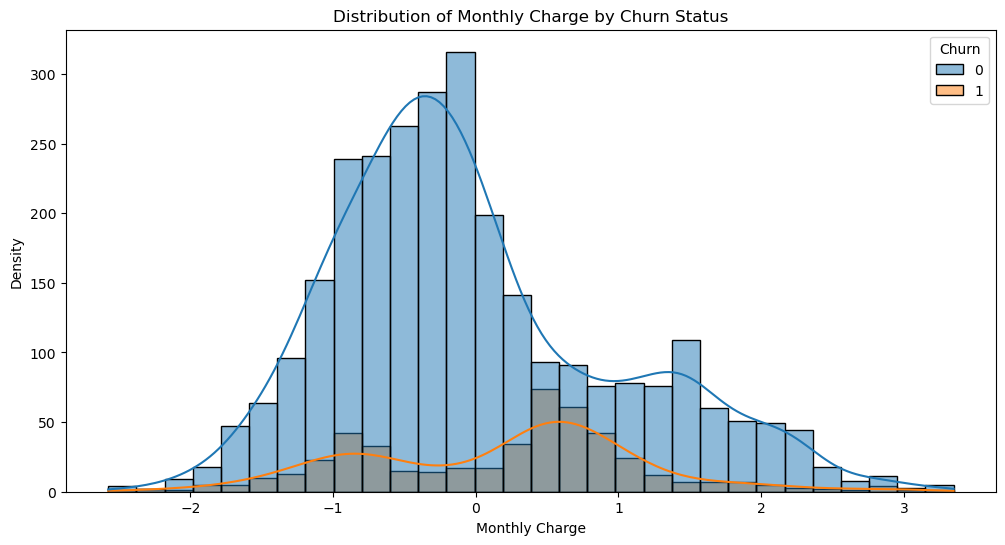

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# suppress warning by seaborn
warnings.simplefilter(action='ignore', category=FutureWarning)

# Distribution of MonthlyCharge for churners and non-churners
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='MonthlyCharge', hue='Churn',  kde=True, bins=30)
plt.title('Distribution of Monthly Charge by Churn Status')
plt.xlabel('Monthly Charge')
plt.ylabel('Density')
plt.show()

This histogram shows the distribution of MonthlyCharge for customers who churned (indicated by 1) and those who did not churn (indicated by 0).

Non-Churners (0): The distribution for non-churners is centered around the mean and shows a high density, particularly in the middle range of monthly charges. Most non-churning customers have moderate monthly charges.
Churners (1): The distribution for churners is lower overall, but we can observe a slight increase in density for customers with higher monthly charges. This suggests that customers with higher monthly charges may be more likely to churn.

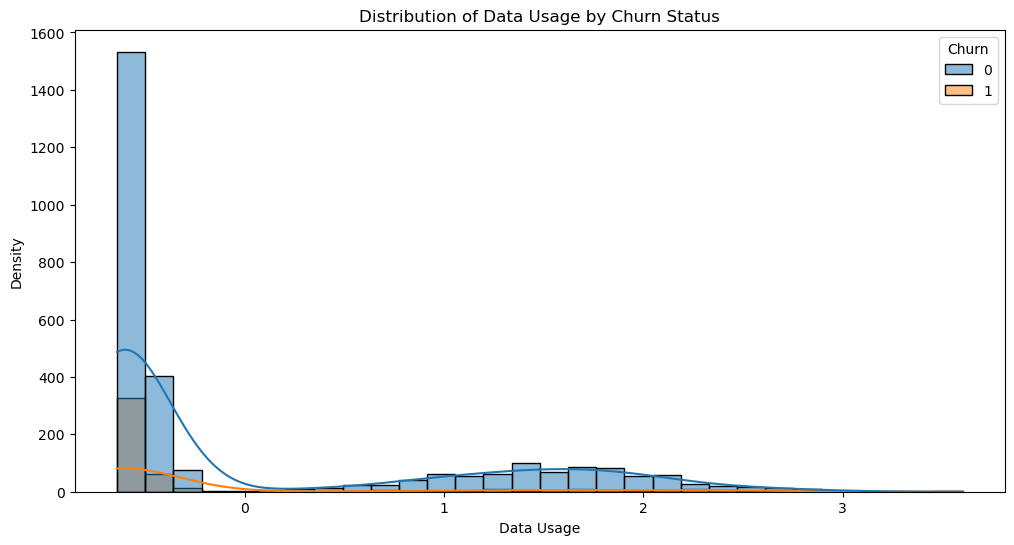

In [32]:
# Distribution of DataUsage for churners and non-churners
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='DataUsage', hue='Churn', kde=True, bins=30)
plt.title('Distribution of Data Usage by Churn Status')
plt.xlabel('Data Usage')
plt.ylabel('Density')
plt.show()

This histogram illustrates the distribution of DataUsage for churners and non-churners.

Non-Churners (0): The majority of non-churning customers have low data usage, which accounts for the high density at the lower end of the DataUsage scale.
Churners (1): Churners have a slightly more spread-out distribution, although they still tend to cluster around lower data usage. This indicates that both low and high data usage customers may churn, but the overall density is low for churners.

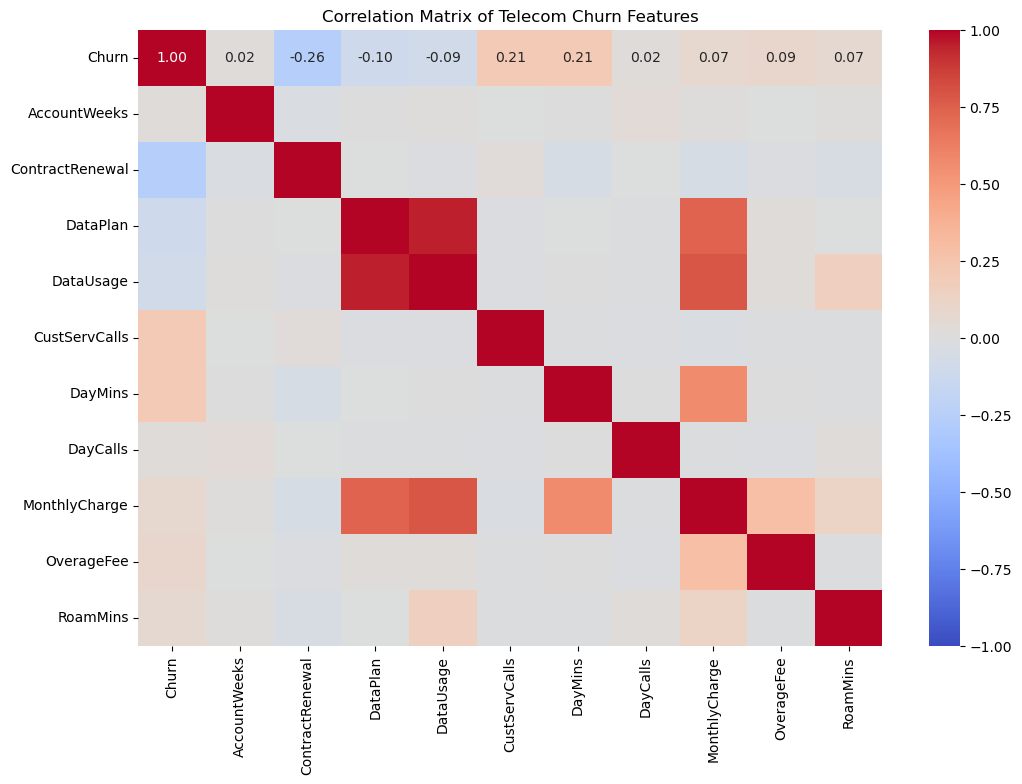

In [33]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation Matrix of Telecom Churn Features')
plt.show()

Key Observations
Churn and ContractRenewal:

Negative Correlation (-0.26): There is a moderate negative correlation between Churn and ContractRenewal. This suggests that customers who recently renewed their contracts are less likely to churn. This aligns with the idea that contract renewals are a key retention factor.
Churn and CustServCalls:

Positive Correlation (0.21): There is a moderate positive correlation between Churn and CustServCalls. This indicates that customers with more customer service calls are more likely to churn, possibly due to unresolved issues or dissatisfaction.
Churn and DayMins / MonthlyCharge:

Positive Correlation (0.21): Both DayMins (daytime minutes used) and MonthlyCharge show a moderate positive correlation with Churn. This suggests that higher usage and higher charges may increase the likelihood of churn, possibly due to cost concerns.
Other Feature Correlations:

DataUsage and MonthlyCharge: There is a positive correlation between DataUsage and MonthlyCharge, which makes sense since higher data usage would likely lead to higher monthly charges.
DayMins and MonthlyCharge: Similarly, DayMins and MonthlyCharge are positively correlated, as higher usage minutes would increase billing amounts.
Low or No Correlation:

Many features, such as AccountWeeks and RoamMins, show very low correlation with Churn and other features, suggesting they may have a limited impact on churn prediction in this dataset.

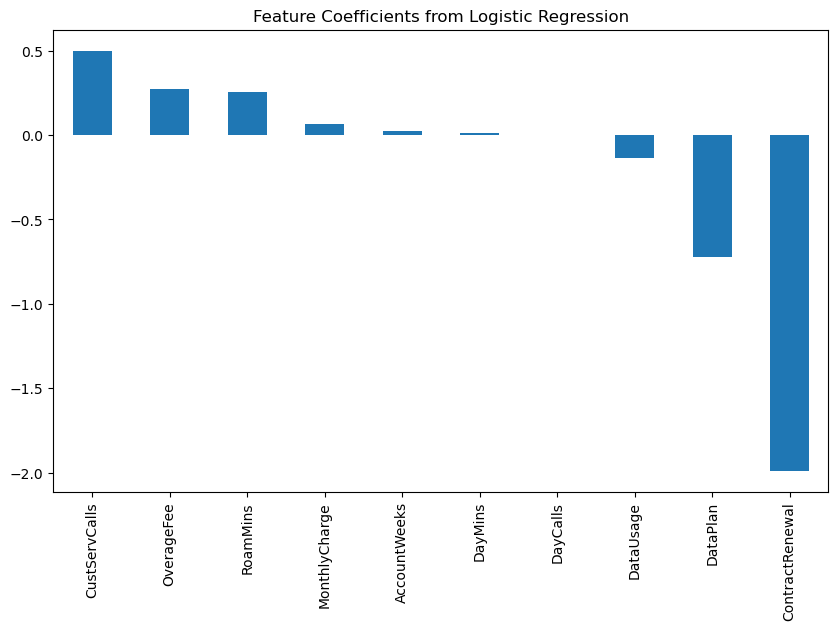

In [34]:
import pandas as pd
# Logistic Regression coefficients
coefficients = pd.Series(log_model.coef_[0], index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
coefficients.plot(kind='bar')
plt.title('Feature Coefficients from Logistic Regression')
plt.show()

Insight: Since Logistic Regression is a linear model, the coefficients indicate the direction and strength of the relationship between each feature and the target variable (churn).

* Positive Coefficients (e.g., CustServCalls, OverageFee, RoamMins): These features increase the likelihood of a customer churning. For instance, higher customer service calls or overage fees are associated with a higher chance of churn.
* Negative Coefficients (e.g., ContractRenewal, DataPlan): These features decrease the likelihood of churn. Customers who have recently renewed their contracts or have a data plan are less likely to churn.

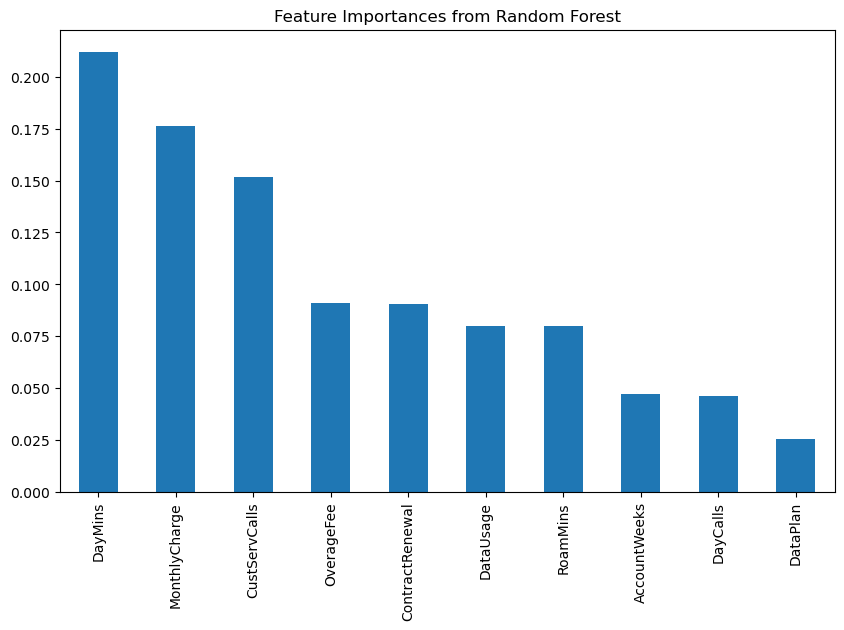

In [35]:
# Random Forest feature importances
feature_importances_rf = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importances_rf.plot(kind='bar')
plt.title('Feature Importances from Random Forest')
plt.show()

Insights: Random Forest uses feature importance scores to indicate how influential each feature is in predicting churn.

* Top Features: The most important features in the Random Forest model are DayMins, MonthlyCharge, and CustServCalls. These features contribute significantly to the model's decisions regarding churn.
* Lesser Features: Features like DayCalls, DataPlan, and AccountWeeks have lower importance scores, suggesting they contribute less to the model’s predictive capability.

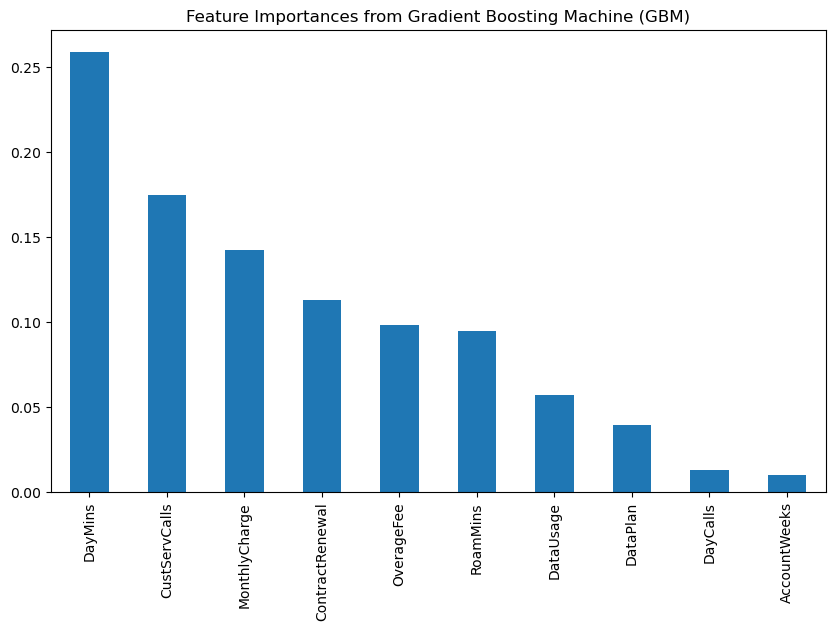

In [36]:
# GBM feature importances
feature_importances_gbm = pd.Series(gbm_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importances_gbm.plot(kind='bar')
plt.title('Feature Importances from Gradient Boosting Machine (GBM)')
plt.show()

Insights: Similar to Random Forest, GBM assigns importance scores to each feature based on its contribution to improving the model’s accuracy.

* Top Features: DayMins, CustServCalls, and MonthlyCharge are identified as the most important features by the GBM model. This alignment with Random Forest confirms that these features are key indicators of churn.
* Lower Importance Features: Features like DataUsage, DayCalls, and AccountWeeks are assigned lower importance, indicating that they have a smaller impact on the model’s performance.

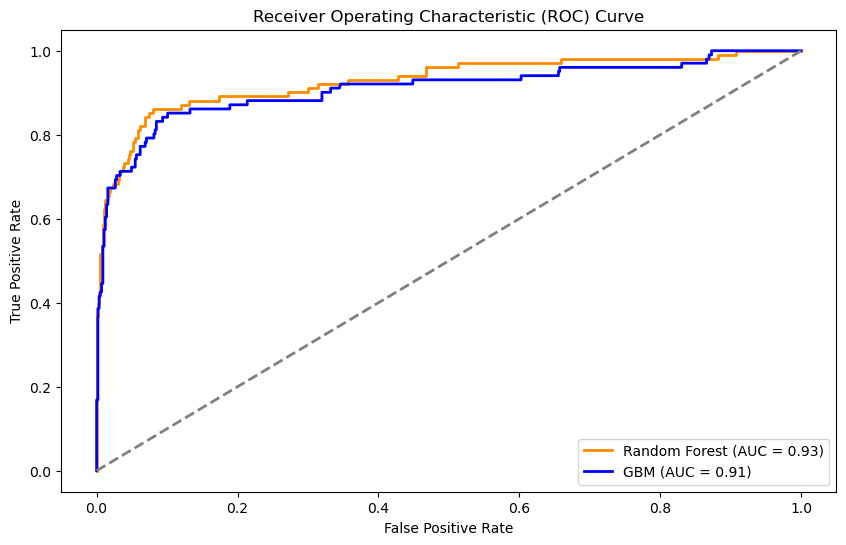

In [37]:
from sklearn.metrics import roc_curve, auc

# ROC curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

# ROC curve for GBM
fpr_gbm, tpr_gbm, _ = roc_curve(y_test, gbm_model.predict_proba(X_test)[:, 1])
roc_auc_gbm = auc(fpr_gbm, tpr_gbm)

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_gbm, tpr_gbm, color='blue', lw=2, label=f'GBM (AUC = {roc_auc_gbm:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Key Elements of the ROC Curve
True Positive Rate (TPR) (Y-axis): Also known as sensitivity or recall, this represents the proportion of actual positives (churners) correctly identified by the model.
False Positive Rate (FPR) (X-axis): This represents the proportion of actual negatives (non-churners) that are incorrectly classified as positives.
Interpreting the Curves
Random Forest (Orange Line):

The Random Forest model achieves an AUC (Area Under the Curve) of 0.93, which indicates a high ability to discriminate between churners and non-churners.
The curve for Random Forest is close to the top-left corner, suggesting a strong balance between TPR and FPR.
GBM (Blue Line):

The GBM model has an AUC of 0.91, slightly lower than the Random Forest model.
Its ROC curve is close to that of Random Forest but slightly below, indicating slightly less accuracy in distinguishing between churners and non-churners.
Summary
Random Forest performs slightly better than GBM, with a higher AUC score (0.93 vs. 0.91).
Both models perform well in predicting churn, as their curves are much better than the random chance line (the diagonal gray dashed line), which has an AUC of 0.5.

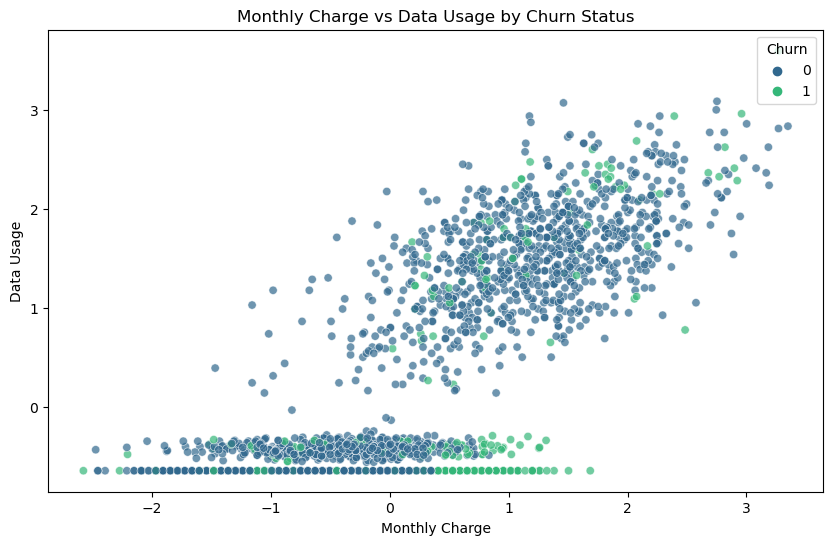

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of MonthlyCharge vs DataUsage, with hue set to Churn status
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='MonthlyCharge', y='DataUsage', hue='Churn', palette="viridis", alpha=0.7)
plt.title('Monthly Charge vs Data Usage by Churn Status')
plt.xlabel('Monthly Charge')
plt.ylabel('Data Usage')
plt.legend(title='Churn', loc='upper right')
plt.show()

Key Observations
Positive Correlation between Monthly Charge and Data Usage:

As Data Usage increases, Monthly Charge also tends to increase. This is expected, as customers who use more data generally incur higher monthly charges.
Churn Distribution:

Non-Churners (Churn = 0): Represented by dark blue points, non-churners are spread throughout the range of monthly charges and data usage levels. They are more concentrated in the middle-to-high data usage and monthly charge regions, suggesting that many retained customers have moderate to high levels of service usage.
Churners (Churn = 1): Represented by light green points, churners are relatively sparse across the chart. However, they are more concentrated in areas with either low data usage or high monthly charges. This pattern suggests that customers with higher monthly costs or very low engagement (low data usage) may be more likely to churn.
Insight into Churn Patterns:

High Monthly Charge: Customers with higher monthly charges are more likely to churn, even if they have moderate or high data usage. This might indicate that high costs are a potential driver of churn.
Low Data Usage: Customers with low data usage also exhibit a tendency to churn, potentially due to underutilization of the service.

#### Conclusion

The predictive analysis provides clear insights into the patterns leading to customer churn. By focusing on improving customer service quality, addressing billing concerns, encouraging contract renewals, and incentivizing data plans, telecom companies can significantly reduce churn and enhance customer retention. Implementing these strategies proactively can help build a more loyal customer base, increase lifetime value, and maintain a competitive edge in the market.